In [1]:
# import importlib
# import active_clustering
from active_clustering import *
# importlib.reload(active_clustering)


# Read the xes data

In [3]:
filename = './xes/filtered_3way_after_80%.xes'
# filename = 'PrepaidTravelCost.xes'
log, VARIANT = read_xes(filename,n_DPI=10)



=READ THE XES FILE
length of log 2293 
length of event 11775 
number of variants : 10


In [4]:
VARIANT

['A,B,C,D,Z',
 'A,C,B,D,Z',
 'A,B,C,D,E,Z',
 'A,F',
 'A,C,G,B,D,Z',
 'A,C,B,D,E,Z',
 'A,H,B,C,D,Z',
 'A,I,B,C,D,Z',
 'A,I,C,B,D,Z',
 'A,C,G,B,D,E,Z']

In [25]:
I=[]
I.append(VARIANT[0])
I.append(VARIANT[2])
I.append(VARIANT[1])

In [14]:
VARIANT - I

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [26]:
for v in VARIANT:
    if v not in I :
        print(v)
        break


A,F


In [23]:
VARIANT

['A,B,C,D,Z',
 'A,C,B,D,Z',
 'A,B,C,D,E,Z',
 'A,F',
 'A,C,G,B,D,Z',
 'A,C,B,D,E,Z',
 'A,H,B,C,D,Z',
 'A,I,B,C,D,Z',
 'A,I,C,B,D,Z',
 'A,C,G,B,D,E,Z']

In [24]:
I

['A,B,C,D,Z', 'A,B,C,D,E,Z']

#  Active clustering

In [ ]:
CS = A_clustering(
    log, VARIANT,
    w = 1,  tf = 1, nb_clus = 20, mcs = 0.5,
    N = 0
)

In [ ]:
import pickle
pickle.dump(CS, open( "active_clustering.p", "wb" ) )

In [ ]:
pickle.dump(log, open('log.p','wb'))
pickle.dump(VARIANT, open('VARIANT.p','wb'))

In [30]:
fig.figure(figsize=(10,10))

AttributeError: 'BarContainer' object has no attribute 'figure'

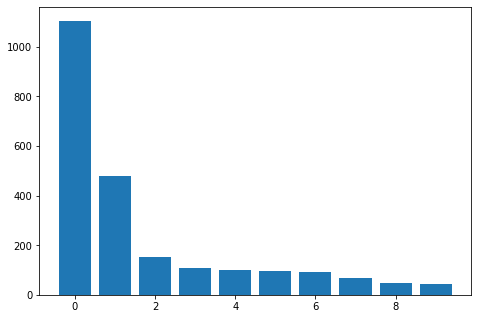

In [ ]:
visualization_total(log, VARIANT, CS, freq_check=True)

# save for the future job

In [ ]:
# Fitness token reply

In [ ]:
from pm4py.algo.conformance.tokenreplay import factory as token_replay
from pm4py.algo.discovery.inductive import factory as inductive_miner
net, initial_marking, final_marking = inductive_miner.apply(log)
replay_result = token_replay.apply(log, net, initial_marking, final_marking)

In [ ]:
log_cs0 = variants_filter.apply(log, CS[1])

In [ ]:
replay_result = token_replay.apply(log, net, initial_marking, final_marking)

In [ ]:

from pm4py.evaluation.replay_fitness import factory as replay_fitness_factory

log_fitness = replay_fitness_factory.evaluate(replay_result, variant="token_replay")


In [ ]:
log_fitness

In [ ]:
#for f1 score measurement 
# RECALL can be approximated by fitness
# ACCURACY can be approximated by precision
from pm4py.evaluation.precision import evaluator as precision_evaluator
net, im, fm = heuristics_miner.apply(variants_filter.apply(log, C))
prec = precision_evaluator.apply(log, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)

In [ ]:
#for complexity measurement
places = net.places
transitions = net.transitions
arcs = net.arcs

In [ ]:
import clustering_util
import importlib
from clustering_util import *
importlib.reload(clustering_util)

In [ ]:
CS = CS_creator(VARIANT, type='ngram', n=3, k=5)

In [ ]:
CS[0]

In [ ]:
visualization_total(log, VARIANT, CS)
